In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [3]:
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_log_error 


In [4]:
df_main=pd.read_csv(r"D:\Hackathons\Machine Hack\AQI\train.csv")

In [58]:
df_main.head()

,City,Datetime,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI_Bucket,month,week,day,hour
0,Jaipur,2019-05-04 01:00:00,60.8,91.5,41.6,37.3,66.7,27.0,1.0,10.5,26.9,2.0,7.6,3.1,5,5,18,4,1
1,Amritsar,2017-04-27 19:00:00,23.8,119.1,14.9,17.1,NaN,28.4,0.0,6.7,19.1,3.1,8.7,3.1,5,4,17,27,19
2,Amaravati,2018-11-12 10:00:00,93.8,182.0,5.5,63.9,NaN,1.8,1.3,23.1,41.7,0.1,0.6,3.1,5,11,46,12,10
3,Kochi,2020-06-19 09:00:00,16.0,26.9,17.4,0.9,0.0,23.6,1.6,27.4,34.8,3.1,0.0,3.1,5,6,25,19,9
4,Ahmedabad,2019-05-16 03:00:00,29.5,138.4,NaN,31.6,26.0,23.6,9.3,NaN,36.9,14.5,86.8,11.5,1,5,20,16,3


In [59]:
df['AQI_Bucket'].unique()

array([5, 1, 3, 4, 6, 0, 2], dtype=int64)

In [68]:
df_main.isna().sum()

City              0
Datetime          0
PM2.5          6661
PM10          10819
NO            25518
NO2            5614
NOx           10422
NH3           20535
CO             5017
SO2           12158
O3            23614
Benzene        8519
Toluene       11004
Xylene        12160
AQI_Bucket        0
dtype: int64

In [69]:
df_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 495512 entries, 0 to 495511
Data columns (total 15 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   City        495512 non-null  object 
 1   Datetime    495512 non-null  object 
 2   PM2.5       488851 non-null  float64
 3   PM10        484693 non-null  float64
 4   NO          469994 non-null  float64
 5   NO2         489898 non-null  float64
 6   NOx         485090 non-null  float64
 7   NH3         474977 non-null  float64
 8   CO          490495 non-null  float64
 9   SO2         483354 non-null  float64
 10  O3          471898 non-null  float64
 11  Benzene     486993 non-null  float64
 12  Toluene     484508 non-null  float64
 13  Xylene      483352 non-null  float64
 14  AQI_Bucket  495512 non-null  int64  
dtypes: float64(12), int64(1), object(2)
memory usage: 56.7+ MB


In [70]:
df_main.shape

(495512, 15)

In [124]:
df_main.dropna().shape

(362643, 15)

<font color=green>We still(after dropping the Nulls) have more than 3.5 lakh rows to train the model

### Treat Nulls
<font color=green><br>Drop all the nulls
<br>Replace with the previous value

In [122]:
df_main.describe()

,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI_Bucket,month,week,day,hour
count,488851.000000,484693.000000,469994.000000,489898.000000,485090.000000,474977.000000,490495.000000,483354.000000,471898.000000,486993.000000,484508.000000,483352.000000,495512.000000,495512.000000,495512.000000,495512.000000,495512.000000
mean,67.594300,119.133609,17.400187,28.893296,32.297654,23.605254,2.193791,14.026952,34.826780,3.092229,8.656081,3.114720,3.002131,6.264569,25.470645,15.777979,11.508537
std,66.518636,79.646784,29.347508,26.634609,36.097291,22.696589,10.491712,17.406665,26.947275,14.433554,17.955378,4.740591,1.999700,3.432076,14.938560,8.803167,6.921059
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000
25%,31.000000,79.600000,4.600000,12.400000,12.800000,12.300000,0.500000,5.600000,16.200000,0.200000,1.200000,2.300000,1.000000,3.000000,13.000000,8.000000,6.000000
50%,60.400000,119.100000,9.800000,25.300000,26.100000,23.600000,0.900000,10.600000,34.000000,1.800000,7.400000,3.100000,3.000000,6.000000,24.000000,16.000000,12.000000
75%,68.200000,119.100000,17.400000,31.900000,32.300000,23.600000,2.000000,14.000000,41.600000,3.100000,8.700000,3.100000,5.000000,9.000000,38.000000,23.000000,18.000000
max,1000.000000,1000.000000,500.000000,499.500000,498.300000,498.500000,498.600000,200.000000,497.600000,498.100000,499.400000,500.000000,6.000000,12.000000,53.000000,31.000000,23.000000


In [125]:
df_main.median()

PM2.5          60.4
PM10          119.1
NO              9.8
NO2            25.3
NOx            26.1
NH3            23.6
CO              0.9
SO2            10.6
O3             34.0
Benzene         1.8
Toluene         7.4
Xylene          3.1
AQI_Bucket      3.0
dtype: float64

In [5]:
df_main['Datetime']=pd.to_datetime(df_main['Datetime'])

In [6]:
df_main['Datetime']=pd.to_datetime(df_main['Datetime'])
df=df_main
df['month']=df['Datetime'].dt.month
df['week']=df['Datetime'].dt.week
df['day']=df['Datetime'].dt.day
df['hour']=df['Datetime'].dt.hour

In [76]:
df.head()

,City,Datetime,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI_Bucket,month,week,day,hour
0,Jaipur,2019-05-04 01:00:00,60.8,91.5,41.6,37.3,66.7,27.0,1.0,10.5,26.9,2.0,7.6,3.1,5,5,18,4,1
1,Amritsar,2017-04-27 19:00:00,23.8,119.1,14.9,17.1,NaN,28.4,0.0,6.7,19.1,3.1,8.7,3.1,5,4,17,27,19
2,Amaravati,2018-11-12 10:00:00,93.8,182.0,5.5,63.9,NaN,1.8,1.3,23.1,41.7,0.1,0.6,3.1,5,11,46,12,10
3,Kochi,2020-06-19 09:00:00,16.0,26.9,17.4,0.9,0.0,23.6,1.6,27.4,34.8,3.1,0.0,3.1,5,6,25,19,9
4,Ahmedabad,2019-05-16 03:00:00,29.5,138.4,NaN,31.6,26.0,23.6,9.3,NaN,36.9,14.5,86.8,11.5,1,5,20,16,3


### Exploratory Data Analysis

<font color=red>**Note-> All the temporary DataFrames will be made with the reference of 'df'**

In [20]:
df.corr()

,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI_Bucket,month,week,day,hour
PM2.5,1.000000,0.515895,0.358383,0.293572,0.334537,0.162574,0.080840,0.114675,0.044923,0.031954,0.116373,0.073945,0.001847,0.036510,0.033465,-0.009792,-0.022875
PM10,0.515895,1.000000,0.350419,0.322278,0.368153,0.193097,0.035782,0.154953,0.091441,0.031856,0.127099,0.034219,0.001475,-0.004081,-0.009853,-0.015084,0.018800
NO,0.358383,0.350419,1.000000,0.413841,0.743354,0.135522,0.324164,0.128204,-0.103183,0.069954,0.178318,0.098642,0.002484,0.022917,0.021981,-0.001646,-0.010677
NO2,0.293572,0.322278,0.413841,1.000000,0.564700,0.151073,0.254733,0.285044,0.055316,0.050408,0.252382,0.143802,0.002115,0.028940,0.026396,-0.005057,0.078650
NOx,0.334537,0.368153,0.743354,0.564700,1.000000,0.122404,0.277647,0.154781,-0.068562,0.072971,0.206241,0.100098,0.003130,0.018798,0.017417,-0.005841,0.015044
NH3,0.162574,0.193097,0.135522,0.151073,0.122404,1.000000,0.012724,-0.007319,0.039562,-0.004539,0.015540,-0.001114,-0.001915,0.014659,0.015227,0.003100,-0.002448
CO,0.080840,0.035782,0.324164,0.254733,0.277647,0.012724,1.000000,0.240401,-0.045856,0.070145,0.239920,0.164670,0.001332,-0.000194,-0.000489,-0.000125,0.019812
SO2,0.114675,0.154953,0.128204,0.285044,0.154781,-0.007319,0.240401,1.000000,0.093385,0.026560,0.210696,0.148435,0.000082,-0.018847,-0.020871,-0.001769,0.006336
O3,0.044923,0.091441,-0.103183,0.055316,-0.068562,0.039562,-0.045856,0.093385,1.000000,-0.008085,0.029948,-0.003987,-0.001737,-0.057767,-0.057745,-0.005593,0.126862
Benzene,0.031954,0.031856,0.069954,0.050408,0.072971,-0.004539,0.070145,0.026560,-0.008085,1.000000,0.681299,0.109603,0.001966,-0.007855,-0.008435,-0.003483,0.002827


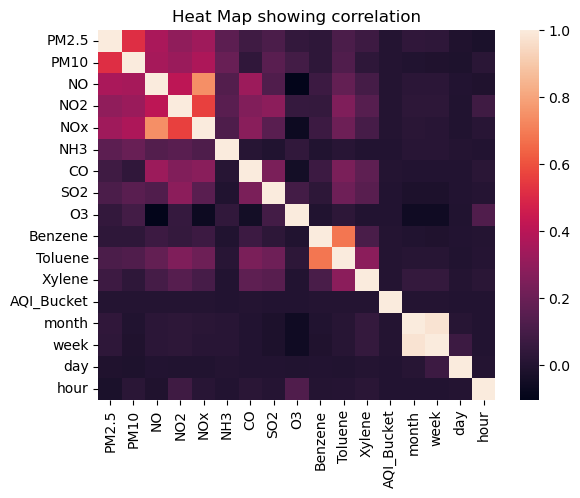

In [134]:
sns.heatmap(df.corr())
plt.title('Heat Map showing correlation')
plt.show()

<font color=blue> **A line chart showing the variation of Pollution levels of all the cities combined in India**

In [80]:
print('Begin Date- ', df['Datetime'].min(), '\nEnd Date- ', df['Datetime'].max() )

Begin Date-  2015-01-01 01:00:00 
End Date-  2020-07-01 00:00:00


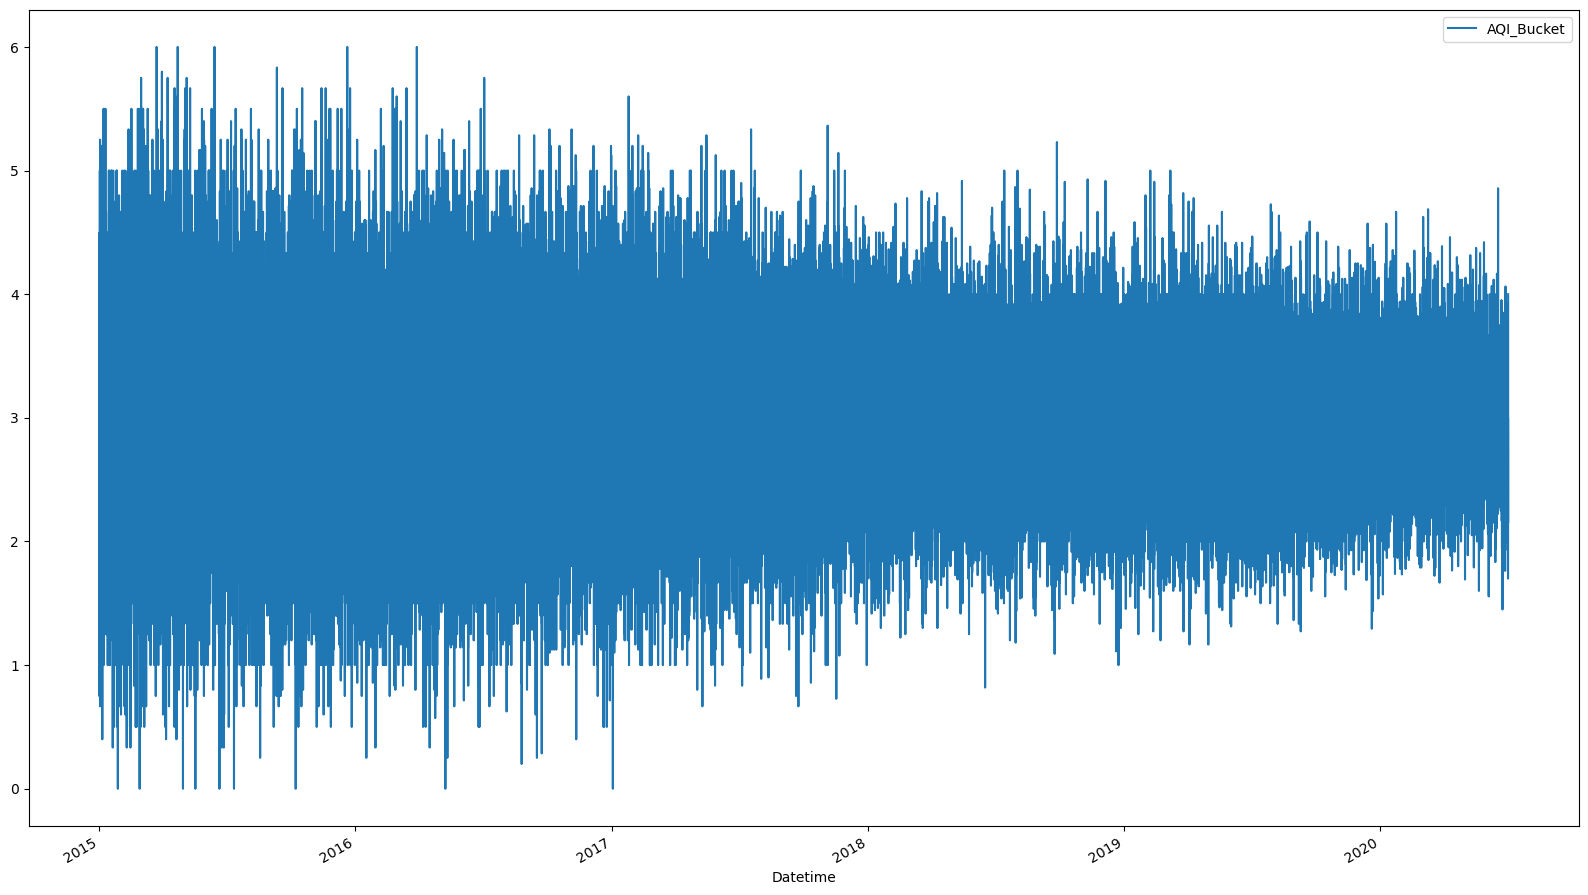

In [91]:
# Make a temporary df which has date as index and average of AQI of all the cities for that date

df_temp=df.groupby(['Datetime']).agg({'AQI_Bucket':'mean'})
df_temp.plot(figsize=(20,12))
plt.show()

In [109]:
print('Mean of AQI-Bucket from 2015 to 2016 ', df[df['Datetime']<'2016-01-01']['AQI_Bucket'].mean())
print('Mean of AQI-Bucket from 2016 to 2017 ', df[ (df['Datetime']>='2016-01-01') & (df['Datetime']<'2017-01-01')]['AQI_Bucket'].mean())
print('Mean of AQI-Bucket from 2017 to 2018 ', df[ (df['Datetime']>='2017-01-01') & (df['Datetime']<'2018-01-01')]['AQI_Bucket'].mean())
print('Mean of AQI-Bucket from 2018 to 2019 ', df[ (df['Datetime']>='2018-01-01') & (df['Datetime']<'2019-01-01')]['AQI_Bucket'].mean())
print('Mean of AQI-Bucket from 2019 to 2020 ', df[ (df['Datetime']>='2019-01-01') & (df['Datetime']<'2020-01-01')]['AQI_Bucket'].mean())

Mean of AQI-Bucket from 2015 to 2016  2.993445692883895
Mean of AQI-Bucket from 2016 to 2017  2.992791746378792
Mean of AQI-Bucket from 2017 to 2018  3.006801250921665
Mean of AQI-Bucket from 2018 to 2019  3.007160871085912
Mean of AQI-Bucket from 2019 to 2020  3.003945262483995


<font color=green>We have an idea that overall average AQI is making lower highs and higher lows and overall is almost constant at 3

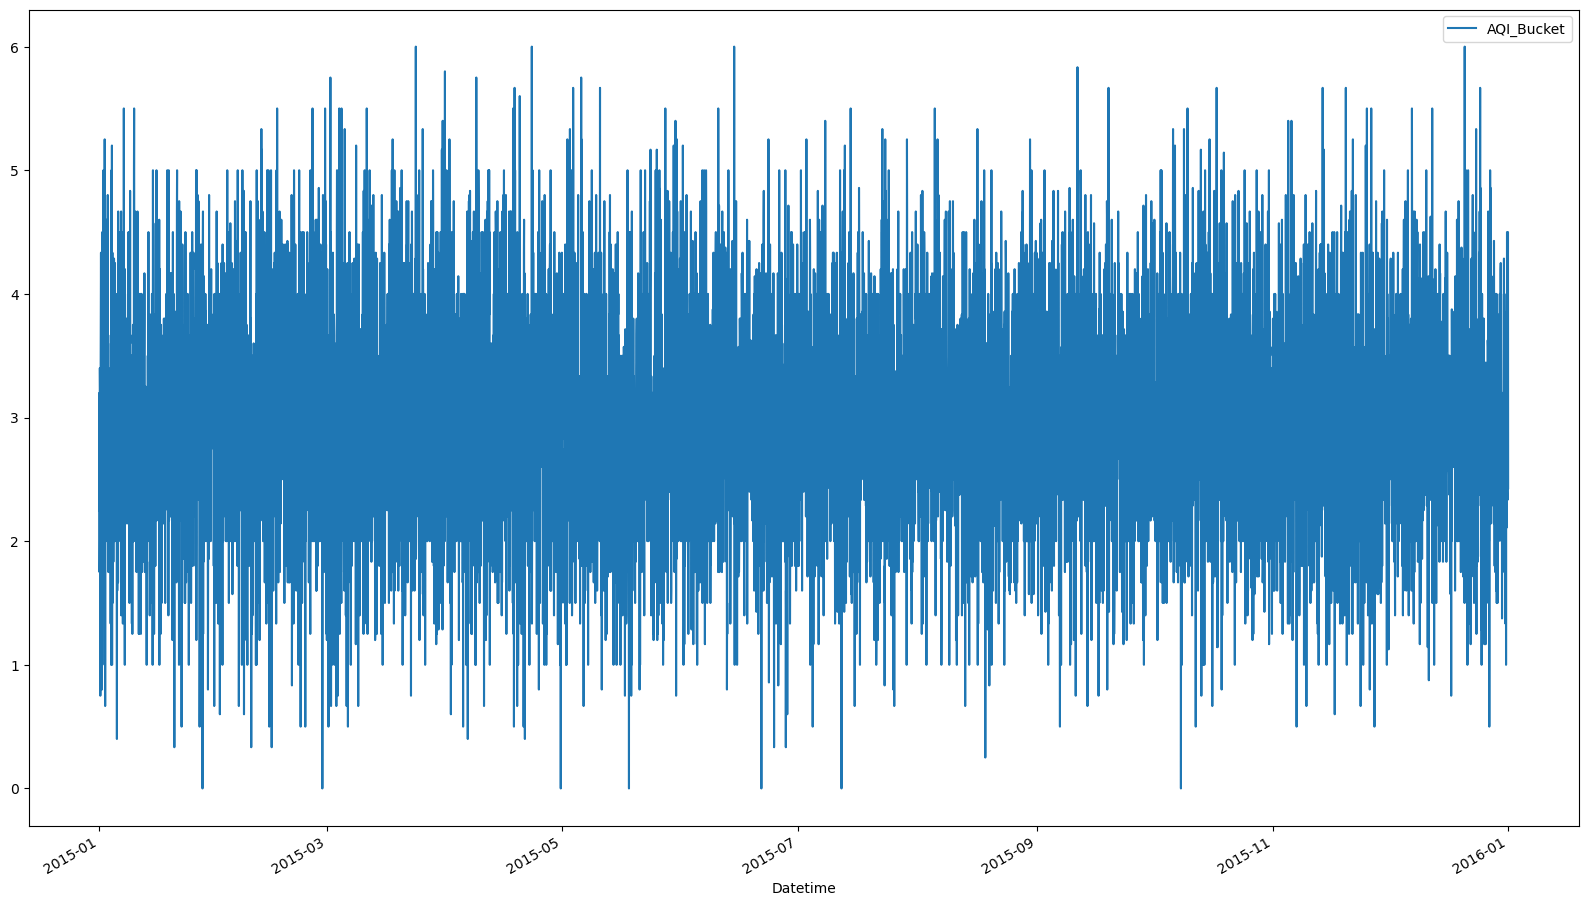

In [94]:
# Now lets plot all the city average AQI for just one year 

df_temp=df[df['Datetime']<='2016-01-01']
df_temp=df_temp.groupby(['Datetime']).agg({'AQI_Bucket':'mean'})
df_temp.plot(figsize=(20,12))
plt.show()

<font color=green> If we look closely we can see some hidden pattern, seasonality in the data

### Now lets plot it for just one City - Aizawl

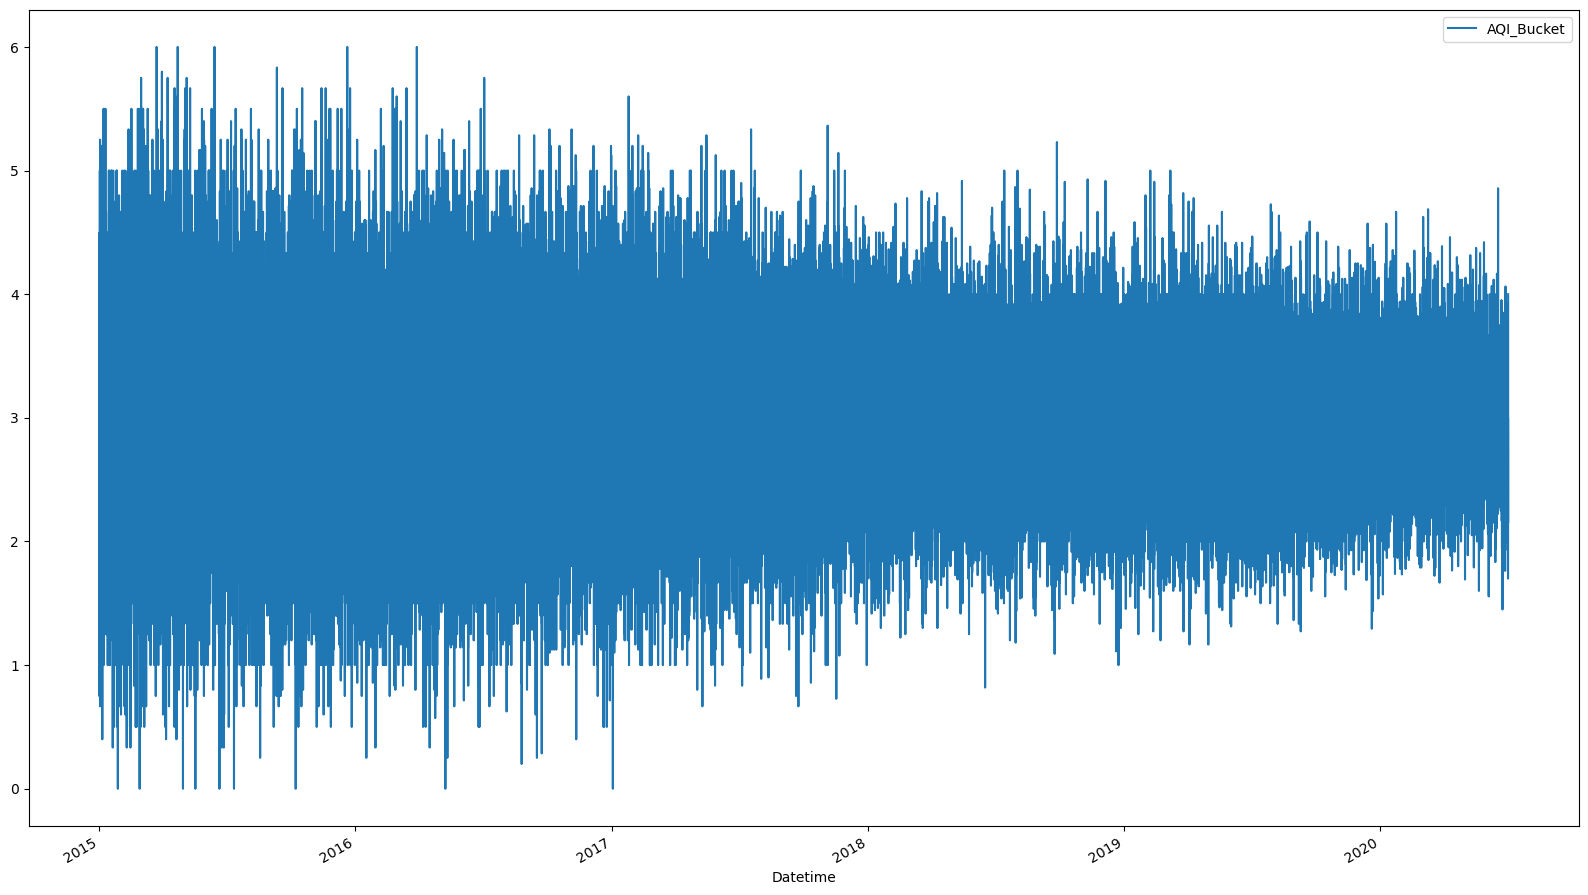

In [90]:

df_temp=df[df['City']=='Aizawal']
df_temp=df.groupby(['Datetime']).agg({'AQI_Bucket':'mean'})
df_temp.plot(figsize=(20,12))
plt.show()

<font color=green>This shows similar pattern as that for all the cities combined

### Time Series Analysis

In [130]:
df_temp=df
df_temp['Date']=pd.to_datetime(df_temp['Datetime']).dt.date
df_temp['Date']=pd.to_datetime(df_temp['Date'])

In [31]:
# Making dataframe for one year 2015 to 2016

df_temp=df_temp[df_temp['Date']<='2016-01-01']
df_temp=df_temp.groupby(['Date']).agg({'AQI_Bucket':'mean'})

In [34]:
df_temp.reset_index(inplace=True)
df_temp['Date']=pd.to_datetime
df_temp.set_index('Date',inplace=True)

In [35]:
df_temp.head()

,AQI_Bucket
Date,
2015-01-01,2.575758
2015-01-02,3.177570
2015-01-03,2.970297
2015-01-04,2.800000
2015-01-05,2.931034


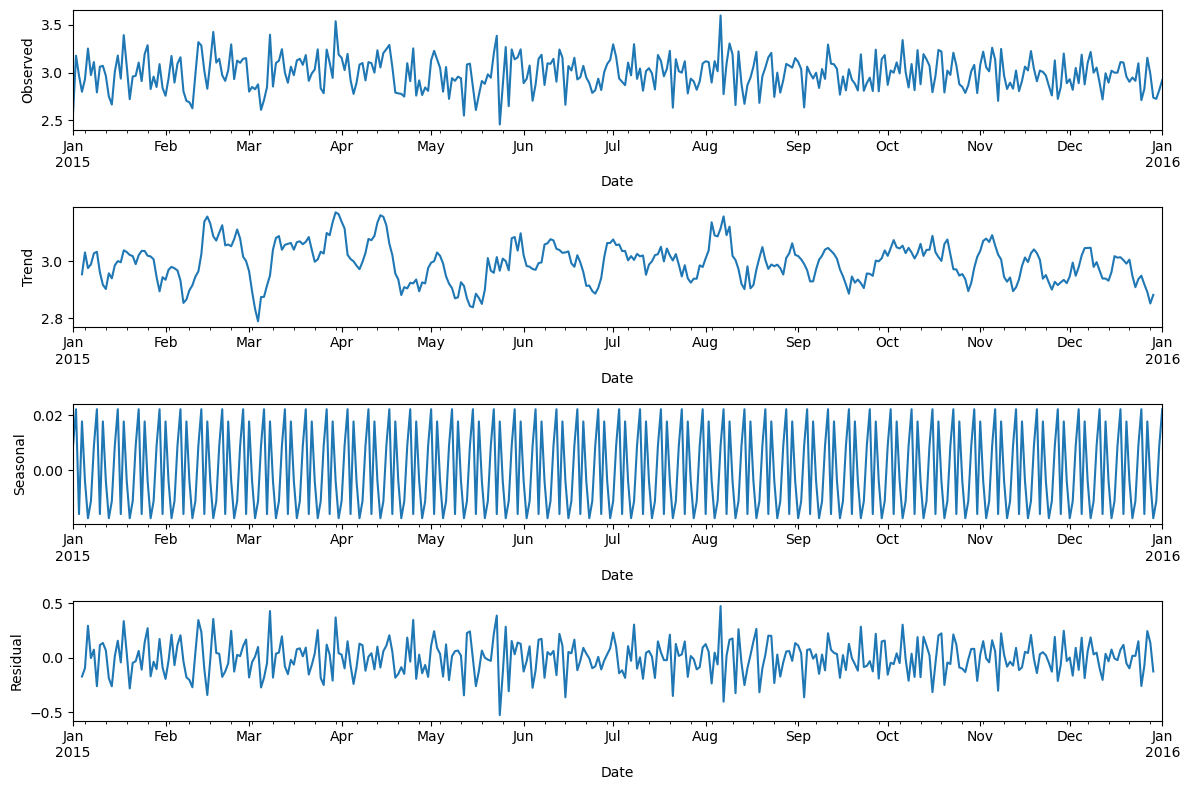

In [36]:
# For one year

result = seasonal_decompose(df_temp['AQI_Bucket'], model='add')

# Visualize the decomposed components
fig, axes = plt.subplots(4, 1, figsize=(12, 8))
result.observed.plot(ax=axes[0], legend=False)
axes[0].set_ylabel('Observed')
result.trend.plot(ax=axes[1], legend=False)
axes[1].set_ylabel('Trend')
result.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Seasonal')
result.resid.plot(ax=axes[3], legend=False)
axes[3].set_ylabel('Residual')
plt.tight_layout()
plt.show()

<font color=green>There is some seasonality to see it more clearly we will plot for just one quater

In [53]:
df_temp.reset_index(inplace=True)
df_temp=df_temp[ (df_temp['Date']>'2015-12-31') & (df_temp['Date']<'2016-02-01')]

### For one quater

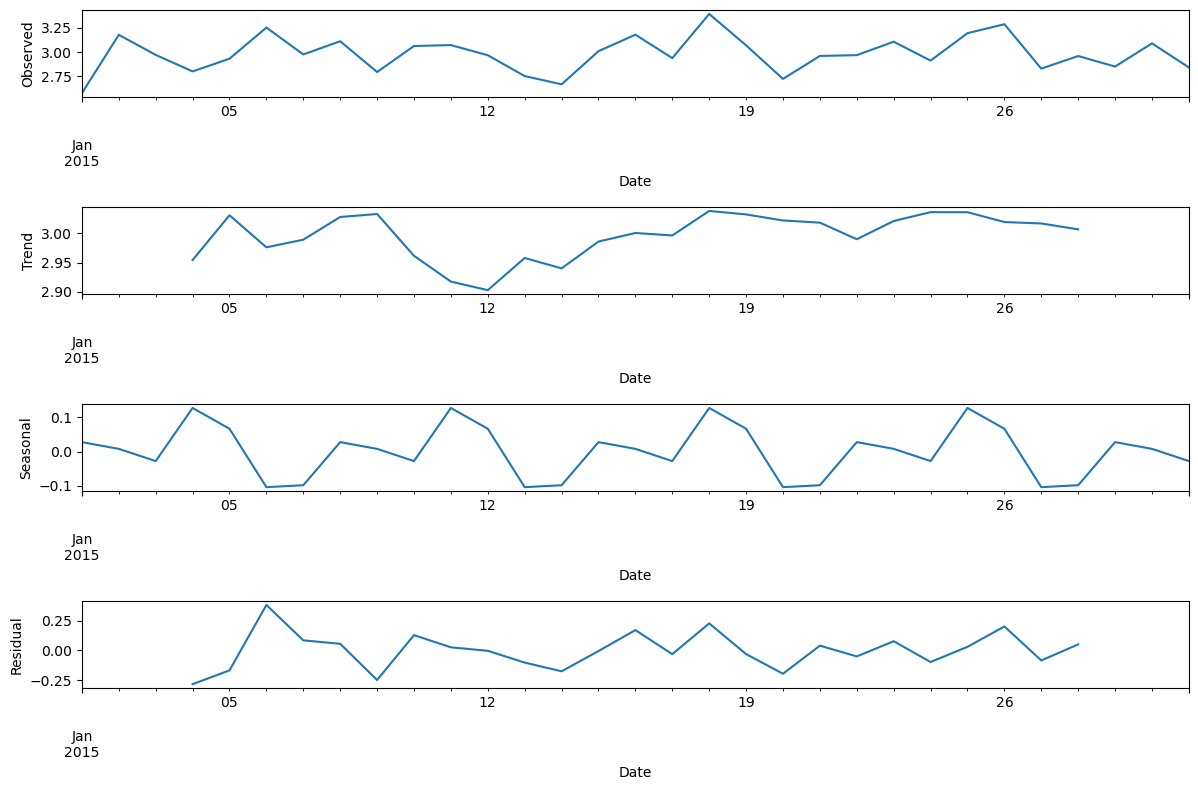

In [52]:

df_temp.set_index('Date',inplace=True)

result = seasonal_decompose(df_temp['AQI_Bucket'], model='add')

# Visualize the decomposed components
fig, axes = plt.subplots(4, 1, figsize=(12, 8))
result.observed.plot(ax=axes[0], legend=False)
axes[0].set_ylabel('Observed')
result.trend.plot(ax=axes[1], legend=False)
axes[1].set_ylabel('Trend')
result.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Seasonal')
result.resid.plot(ax=axes[3], legend=False)
axes[3].set_ylabel('Residual')
plt.tight_layout()
plt.show()

In [ ]:
# Study about the scale of seasonalty and other graphs

### Just for One Quater for One city

In [147]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 0 entries
Data columns (total 19 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   City        0 non-null      object        
 1   Datetime    0 non-null      datetime64[ns]
 2   PM2.5       0 non-null      float64       
 3   PM10        0 non-null      float64       
 4   NO          0 non-null      float64       
 5   NO2         0 non-null      float64       
 6   NOx         0 non-null      float64       
 7   NH3         0 non-null      float64       
 8   CO          0 non-null      float64       
 9   SO2         0 non-null      float64       
 10  O3          0 non-null      float64       
 11  Benzene     0 non-null      float64       
 12  Toluene     0 non-null      float64       
 13  Xylene      0 non-null      float64       
 14  AQI_Bucket  0 non-null      int64         
 15  month       0 non-null      int64         
 16  week        0 non-null      int64  

<font color=blue>**Count number of times each category has appeared**

In [60]:
df['AQI_Bucket'].value_counts()

5    71123
4    71024
3    71017
0    70975
6    70602
2    70447
1    70324
Name: AQI_Bucket, dtype: int64

<AxesSubplot:>

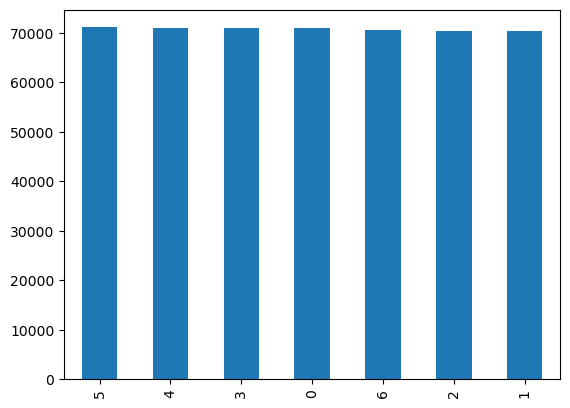

In [59]:
df['AQI_Bucket'].value_counts().plot(kind='bar')

<font color=green>We can say that our dataset is almost balanced

<font color=blue>**See which cities have highest pollution**

In [61]:
df_temp=df.groupby('City').agg({'AQI_Bucket':'mean'}).sort_values('AQI_Bucket',ascending=False)

In [65]:
df_temp.head(5)

,AQI_Bucket
City,
Aizawl,3.044696
Talcher,3.037964
Coimbatore,3.024386
Lucknow,3.019021
Shillong,3.015876


### Box Plot for all the Pollutants

In [55]:
df.columns

Index(['City', 'Datetime', 'PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO',
       'SO2', 'O3', 'Benzene', 'Toluene', 'Xylene', 'AQI_Bucket', 'month',
       'week', 'day', 'hour', 'Date'],
      dtype='object')

In [9]:
# List having all the pollutants

features = ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO','SO2', 'O3', 'Benzene', 'Toluene', 'Xylene']

Text(0, 0.5, 'Levels')

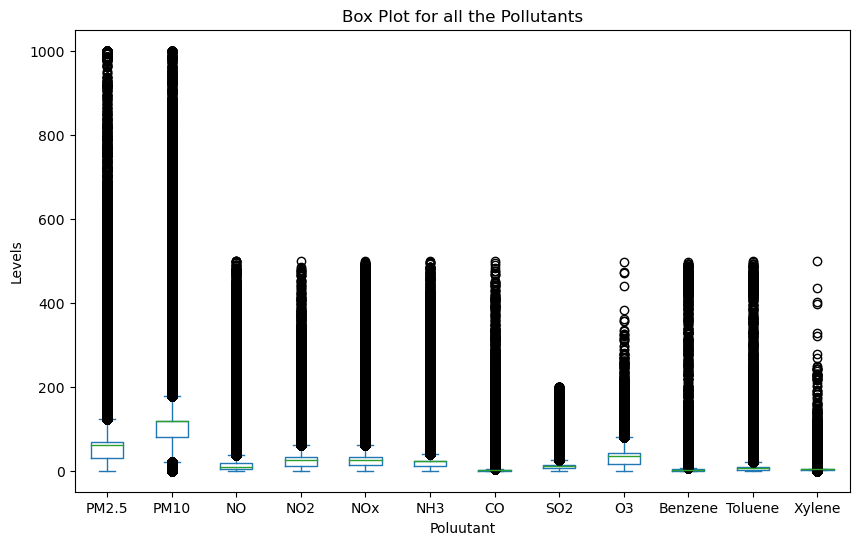

In [56]:
# create a figure and axes for the plot
fig, ax = plt.subplots(figsize=(10, 6))

# create the box plot using the selected features
df[features].plot(kind='box', ax=ax)

# set the title and axis labels
ax.set_title('Box Plot for all the Pollutants')
ax.set_xlabel('Poluutant')
ax.set_ylabel('Levels')

<font color=green>There are lot of outliers in every pollutant values, but we can't remove these as these are the real values

### Distribution Plot of all the Pollutants

In [10]:
PM = ['PM2.5', 'PM10']
Nitrogen = [ 'NO', 'NO2', 'NOx', 'NH3']
Other = ['CO','SO2', 'O3', 'Benzene', 'Toluene', 'Xylene']

#### Distribution for Particulate Matter

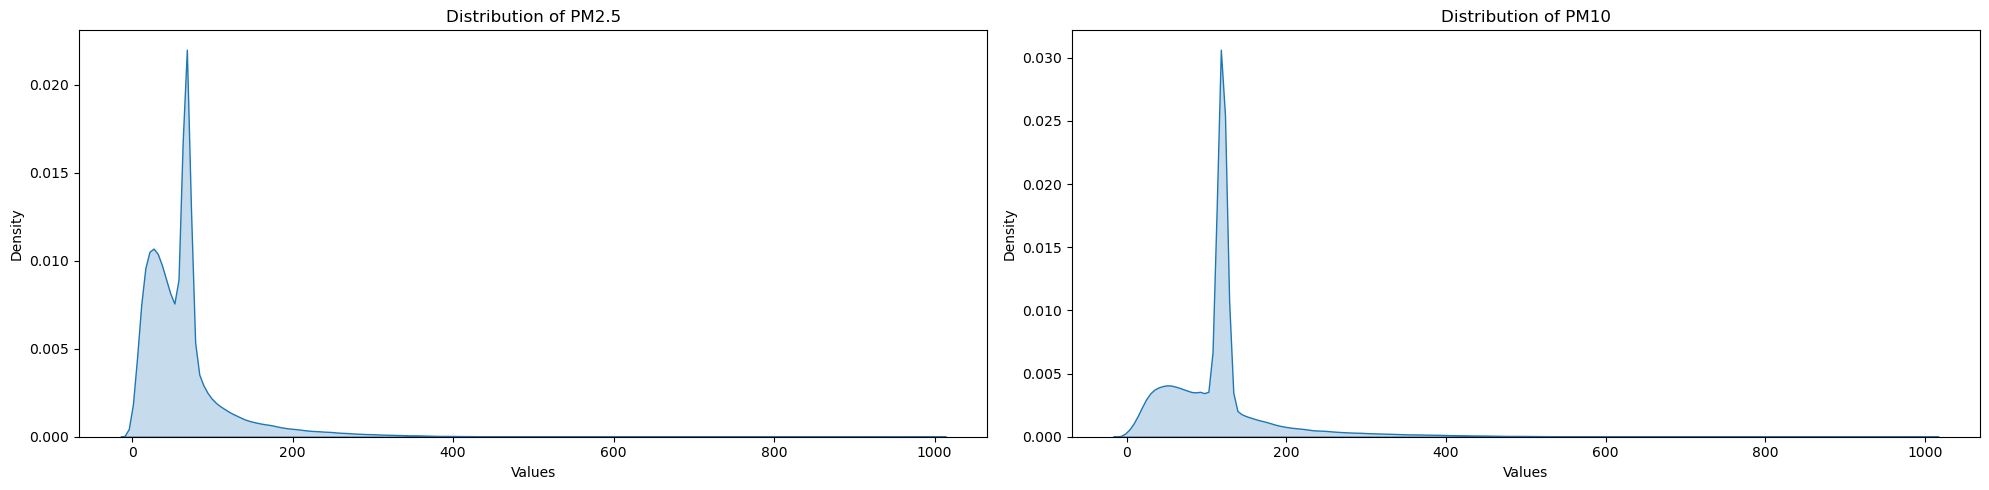

In [68]:

# create a figure and axes for the subplots
fig, axes = plt.subplots(nrows=1, ncols=len(PM), figsize=(20, 5))

# create the distribution plot for each feature on a separate subplot
for i, plot in enumerate(PM):
    sns.kdeplot(data=df[plot], ax=axes[i], shade=True)
    axes[i].set_title(f'Distribution of {plot}')
    axes[i].set_xlabel('Values')
    axes[i].set_ylabel('Density')

# adjust the layout of the subplots
plt.tight_layout()

# show the plot
plt.show()

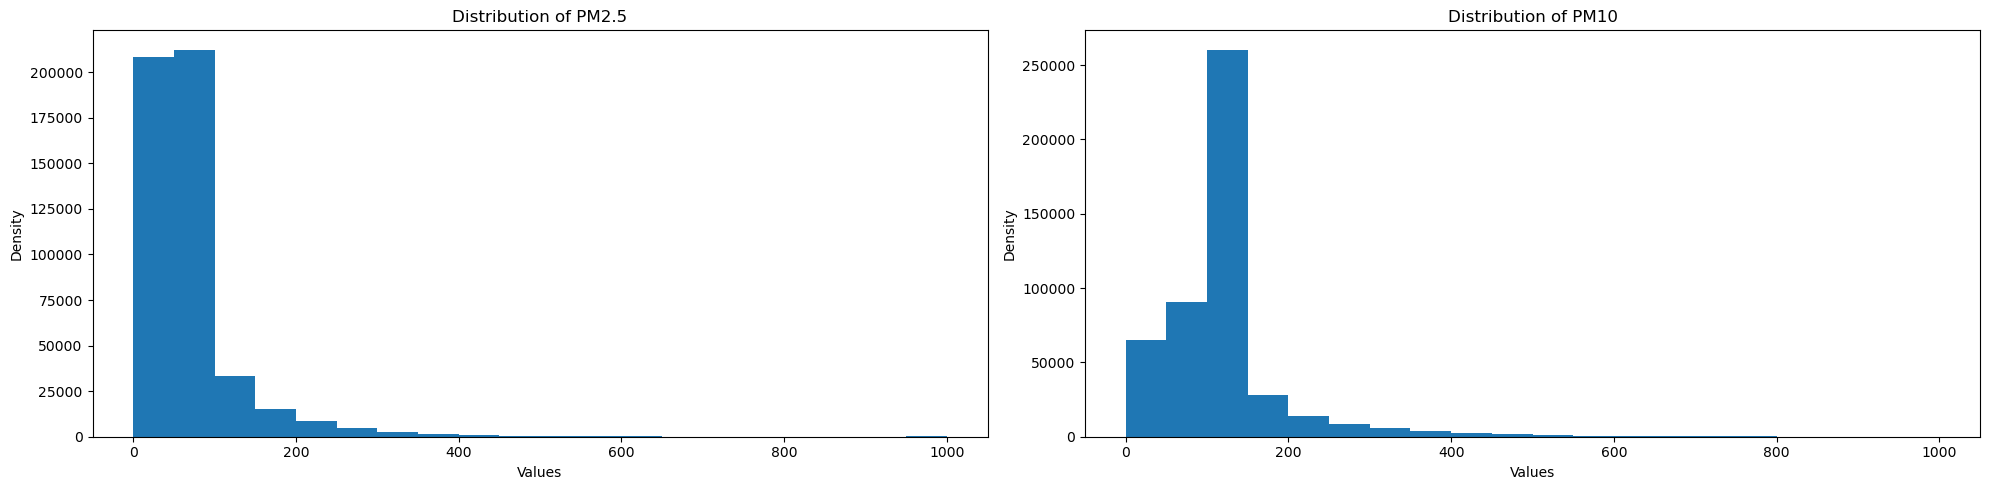

In [77]:
# create a figure and axes for the subplots
fig, axes = plt.subplots(nrows=1, ncols=len(PM), figsize=(20, 5))

# create the distribution plot for each feature on a separate subplot
for i, plot in enumerate(PM):
    axes[i].hist(df[plot], bins=20)
    axes[i].set_title(f'Distribution of {plot}')
    axes[i].set_xlabel('Values')
    axes[i].set_ylabel('Density')

# adjust the layout of the subplots
plt.tight_layout()

# show the plot
plt.show()

#### Distribution for Nitrogen Pollutants

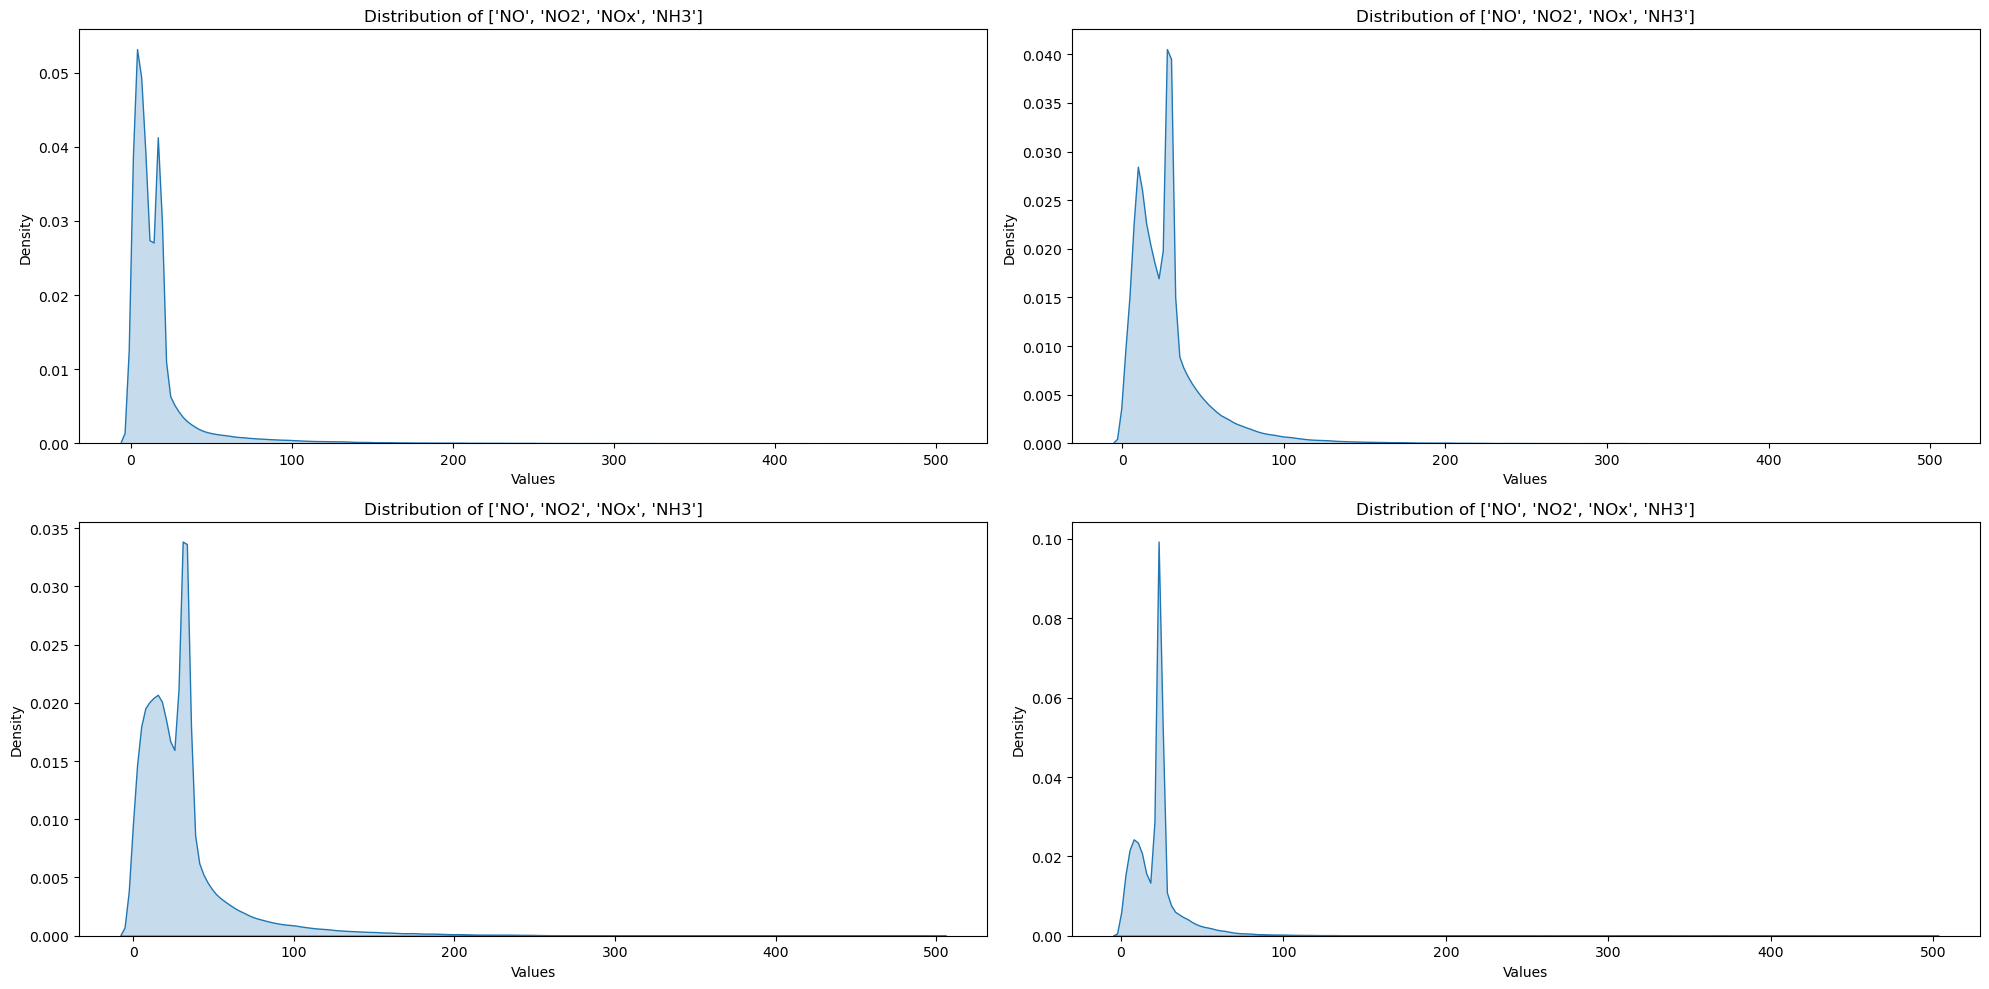

In [75]:
# create a figure and axes for the subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))

# create the distribution plot for each feature on a separate subplot
for i, plot in enumerate(Nitrogen):
    row=i//2
    col=i%2
    sns.kdeplot(data=df[plot], ax=axes[row,col], shade=True)
    axes[row,col].set_title(f'Distribution of {Nitrogen}')
    axes[row,col].set_xlabel('Values')
    axes[row,col].set_ylabel('Density')

# adjust the layout of the subplots
plt.tight_layout()

# show the plot
plt.show()

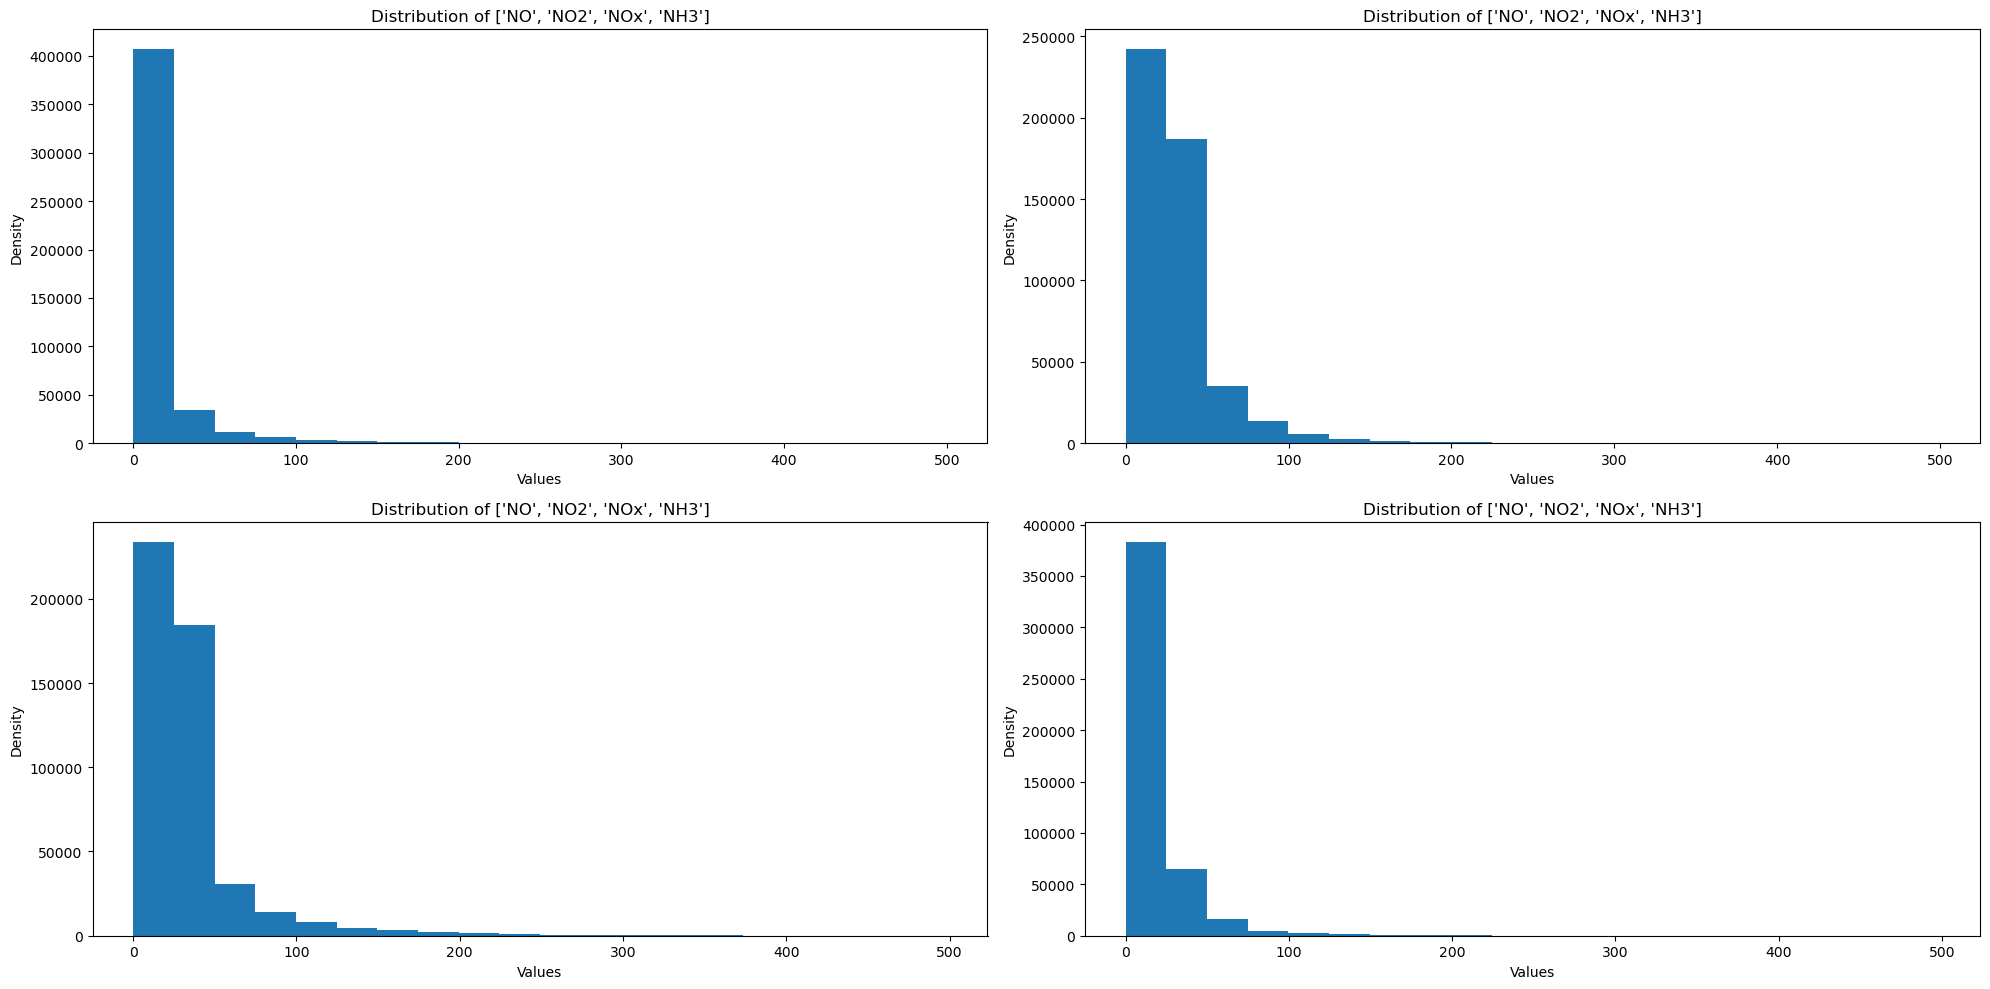

In [78]:
# create a figure and axes for the subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))

# create the distribution plot for each feature on a separate subplot
for i, plot in enumerate(Nitrogen):
    row=i//2
    col=i%2
    axes[row,col].hist(df[plot],bins=20)
    axes[row,col].set_title(f'Distribution of {Nitrogen}')
    axes[row,col].set_xlabel('Values')
    axes[row,col].set_ylabel('Density')

# adjust the layout of the subplots
plt.tight_layout()

# show the plot
plt.show()

#### Distribution for remainig Pollutants

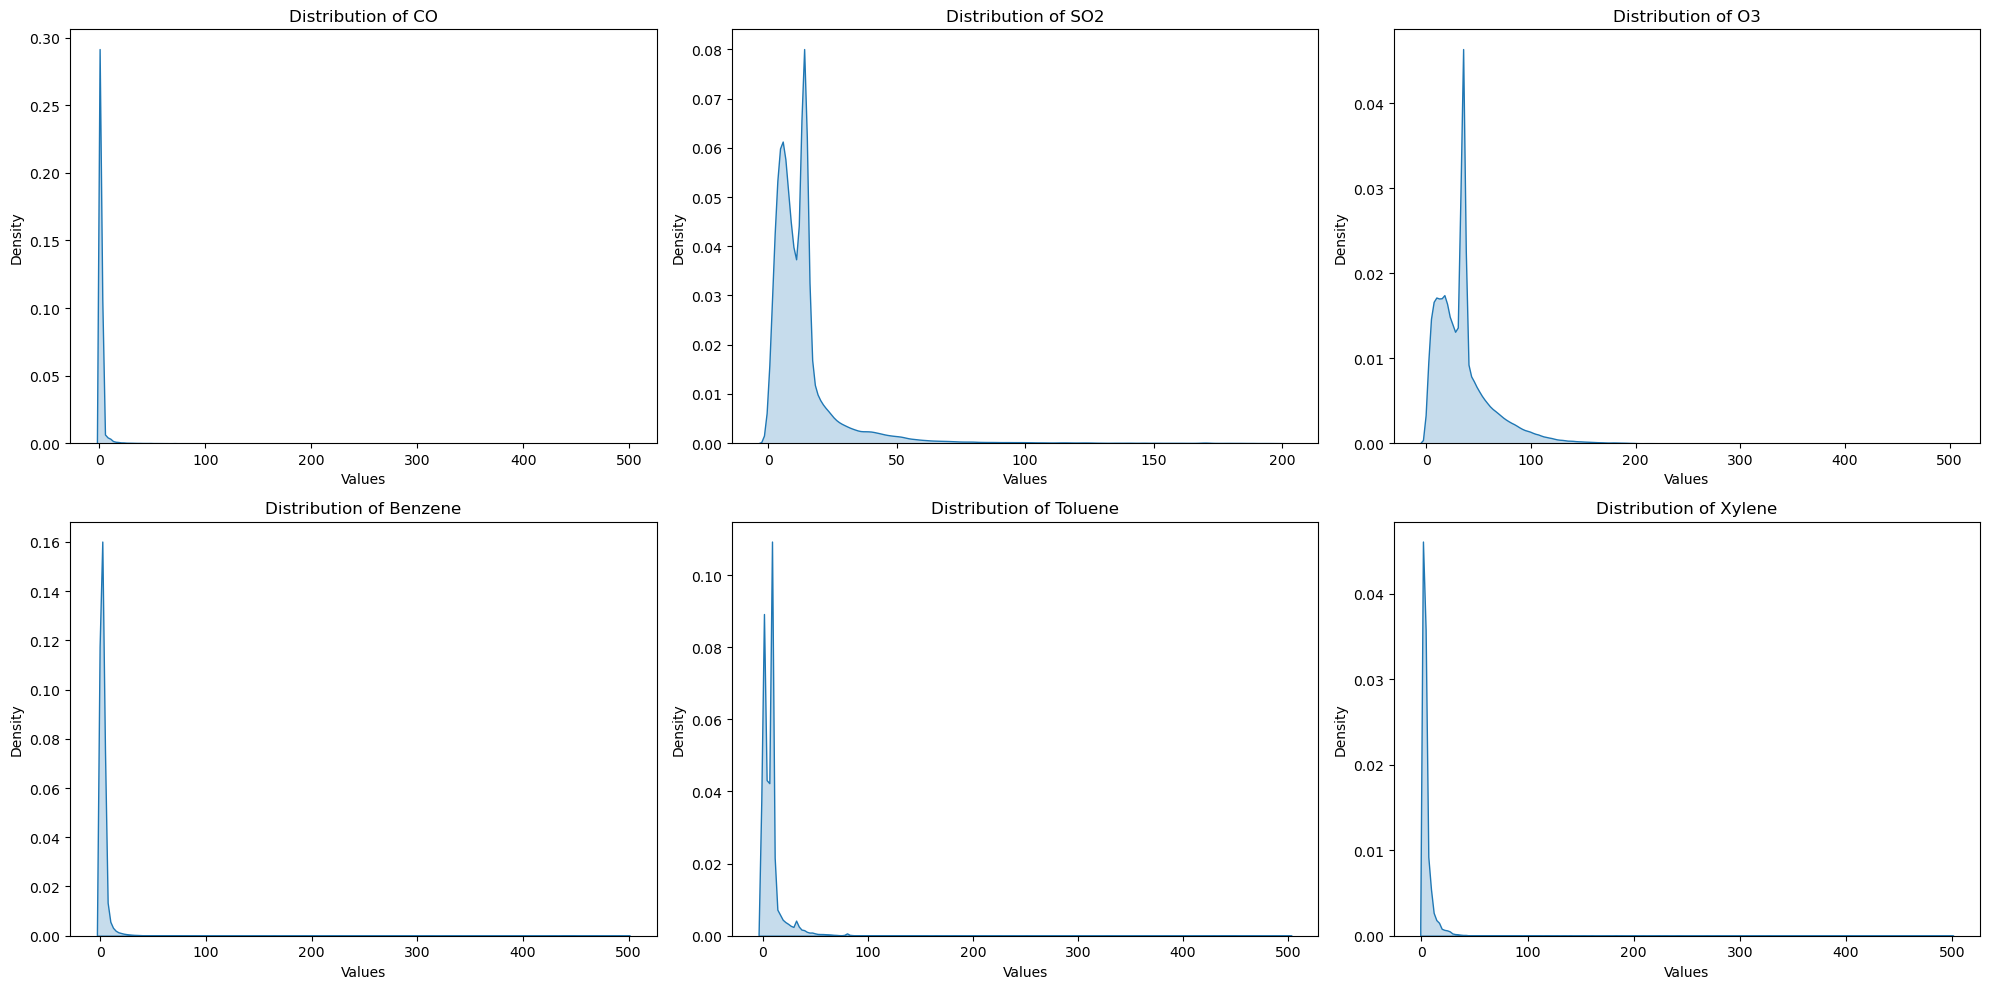

In [73]:
# create a figure and axes for the subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))

# create the distribution plot for each feature on a separate subplot
for i, plot in enumerate(Other):
    row = i // 3
    col = i % 3
    sns.kdeplot(data=df[plot], ax=axes[row, col], shade=True)
    axes[row, col].set_title(f'Distribution of {plot}')
    axes[row, col].set_xlabel('Values')
    axes[row, col].set_ylabel('Density')

# adjust the layout of the subplots
plt.tight_layout()

# show the plot
plt.show()

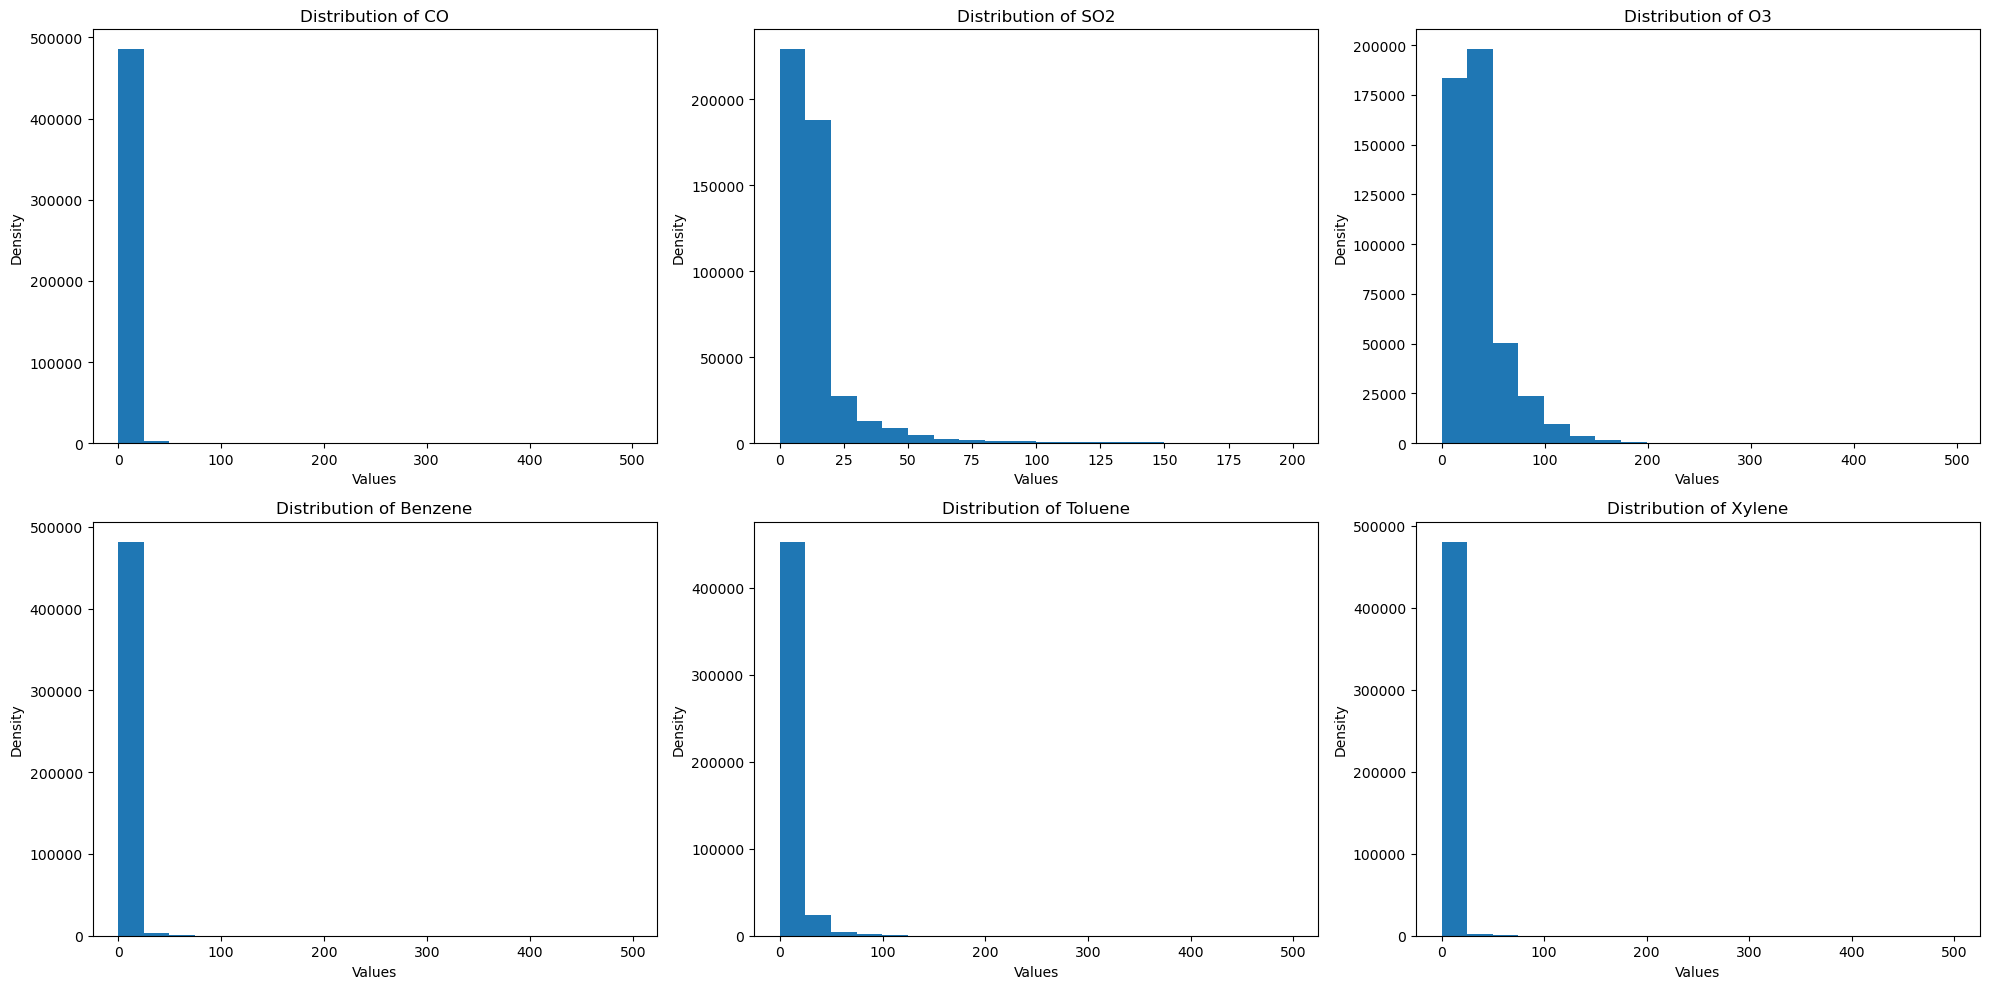

In [79]:
# create a figure and axes for the subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))

# create the distribution plot for each feature on a separate subplot
for i, plot in enumerate(Other):
    row = i // 3
    col = i % 3
    axes[row,col].hist(df[plot],bins=20)
    axes[row, col].set_title(f'Distribution of {plot}')
    axes[row, col].set_xlabel('Values')
    axes[row, col].set_ylabel('Density')

# adjust the layout of the subplots
plt.tight_layout()

# show the plot
plt.show()

<font color=green>**It is visible that all the plots for the pollutants are right skewed
<br>Also these are not just outliers which can be removed, these must be considered in the modeling**

### Calculating Feature Importance using Random Forest
<br>Converted from String("city") to float and removed nulls

In [11]:
# one Hot Encoding - ['City','month', 'week', 'day','hour']

city_one_hot = pd.get_dummies(df['City'])

df_enc = pd.concat( [df.drop(['City'],axis=1), city_one_hot], axis=1)

df_enc.dropna(inplace=True)

In [12]:
df_enc.columns

Index(['Datetime', 'PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2',
       'O3', 'Benzene', 'Toluene', 'Xylene', 'AQI_Bucket', 'month', 'week',
       'day', 'hour', 'Ahmedabad', 'Aizawl', 'Amaravati', 'Amritsar',
       'Bengaluru', 'Bhopal', 'Brajrajnagar', 'Chandigarh', 'Chennai',
       'Coimbatore', 'Delhi', 'Ernakulam', 'Gurugram', 'Guwahati', 'Hyderabad',
       'Jaipur', 'Jorapokhar', 'Kochi', 'Kolkata', 'Lucknow', 'Mumbai',
       'Patna', 'Shillong', 'Talcher', 'Thiruvananthapuram', 'Visakhapatnam'],
      dtype='object')

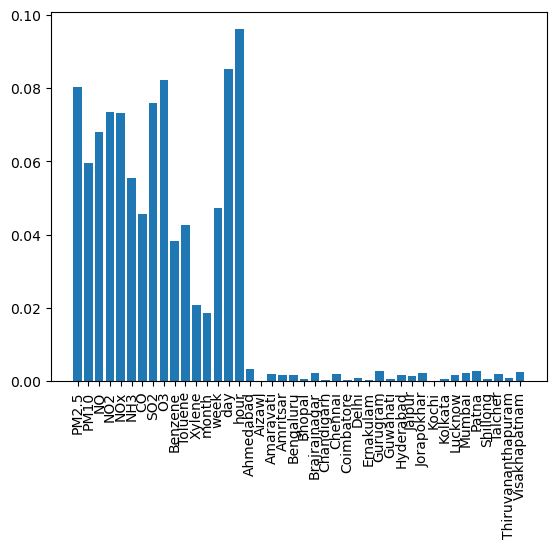

In [15]:
df_enc.drop(['Datetime'],axis=1,inplace=True)

x=df_enc.drop('AQI_Bucket',axis=1)
y=df_enc['AQI_Bucket']

rf=RandomForestRegressor()
rf.fit(x,y)

importances = rf.feature_importances_

# Plot feature importance scores
plt.bar(x.columns, importances)
plt.xticks(rotation=90)
plt.show()

<font color=green>**We can see that most of the pollutants have significant level of importance
<br>But intresting thing is that day and hour have the highest level of importance. Seasonality and periodicity might be the reason for that.**
<br>Let's dive deep into this

In [18]:
impotance_dict=list(zip(x.columns,importances*100))
impotance_dict

[('PM2.5', 8.018936687265033),
 ('PM10', 5.961311536913206),
 ('NO', 6.813765344275422),
 ('NO2', 7.33419930891237),
 ('NOx', 7.323626052288376),
 ('NH3', 5.537112287548558),
 ('CO', 4.573447202368759),
 ('SO2', 7.584644400839374),
 ('O3', 8.224058550563969),
 ('Benzene', 3.8158777443009786),
 ('Toluene', 4.259469273134426),
 ('Xylene', 2.0809963431656318),
 ('month', 1.8726425235047603),
 ('week', 4.733550255934453),
 ('day', 8.520757014523573),
 ('hour', 9.609435822256925),
 ('Ahmedabad', 0.3196320165417416),
 ('Aizawl', 0.007532357431757394),
 ('Amaravati', 0.20257971943660436),
 ('Amritsar', 0.17484932743766024),
 ('Bengaluru', 0.1663341192986074),
 ('Bhopal', 0.061051172728641696),
 ('Brajrajnagar', 0.2153986728751841),
 ('Chandigarh', 0.03542935208296374),
 ('Chennai', 0.1827961620162036),
 ('Coimbatore', 0.04390157746972851),
 ('Delhi', 0.08822407702458399),
 ('Ernakulam', 0.0273212713676629),
 ('Gurugram', 0.2711933557136068),
 ('Guwahati', 0.05627162703842965),
 ('Hyderabad', 

#### Average and Mode of AQI for each day of month, weekday and hour of day

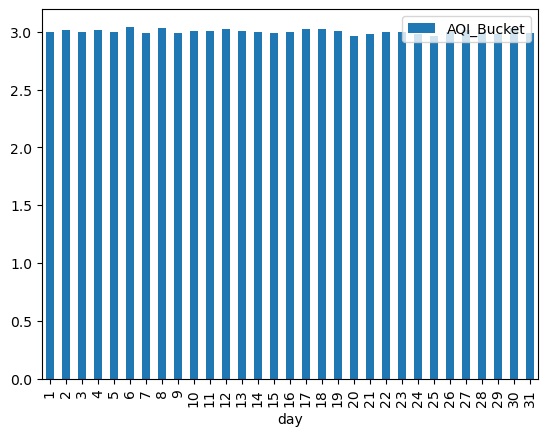

In [99]:
df_temp=df.groupby(['day']).agg({'AQI_Bucket':'mean'})
df_temp.plot(kind='bar')
plt.show()

day_of_week
Friday       [10200, 10158, 10086, 10054, 10045, 10029, 10021]
Monday        [10180, 10168, 10143, 10043, 10041, 10028, 9963]
Saturday     [10201, 10176, 10160, 10146, 10102, 10087, 10034]
Sunday       [10204, 10189, 10154, 10122, 10105, 10039, 10008]
Thursday      [10176, 10134, 10111, 10087, 10084, 10053, 9987]
Tuesday      [10385, 10343, 10112, 10109, 10096, 10031, 10000]
Wednesday     [10333, 10217, 10121, 10107, 10087, 10084, 9969]
Name: AQI_Bucket, dtype: object

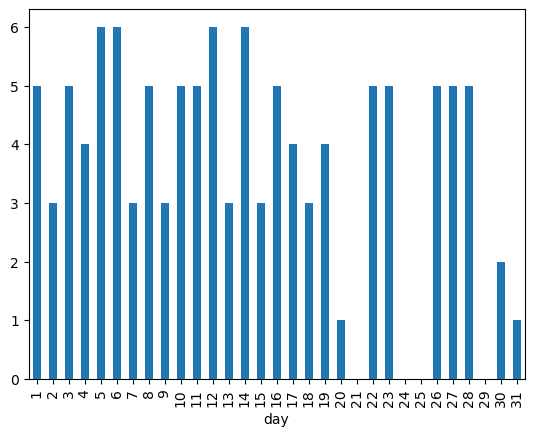

In [100]:
df_temp = df.groupby('day')['AQI_Bucket'].agg(lambda x:x.value_counts().index[0])
df_temp.plot(kind='bar')
plt.show()

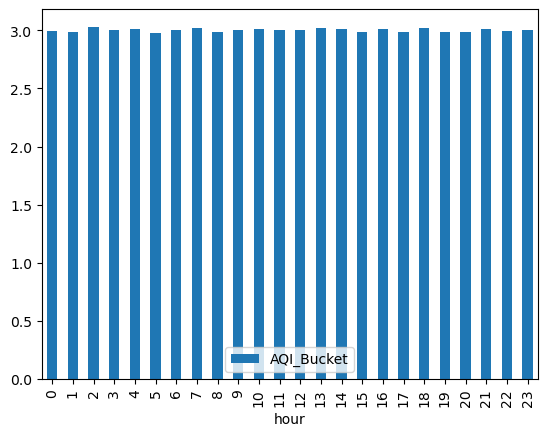

In [101]:
df_temp=df.groupby(['hour']).agg({'AQI_Bucket':'mean'})
df_temp.plot(kind='bar')
plt.show()

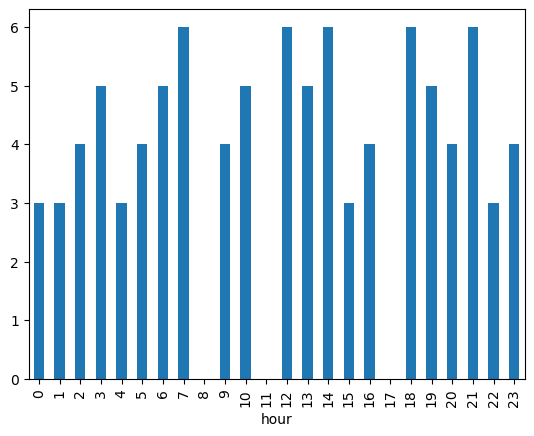

In [104]:
df_temp=df.groupby('hour')['AQI_Bucket'].agg(lambda x:x.value_counts().index[0])
df_temp.plot(kind='bar')
plt.show()

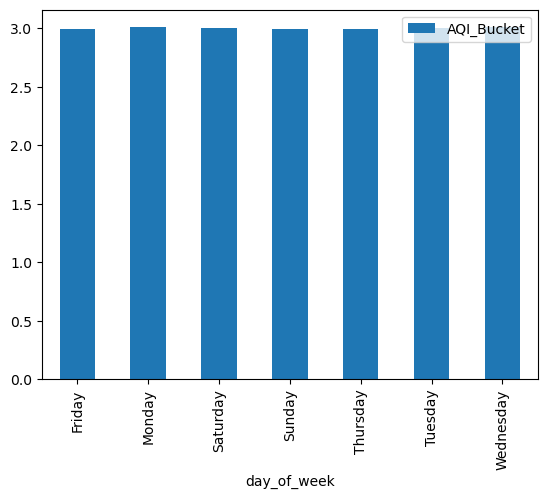

In [105]:
df_temp=df.groupby(['day_of_week']).agg({'AQI_Bucket':'mean'})
df_temp.plot(kind='bar')
plt.show()

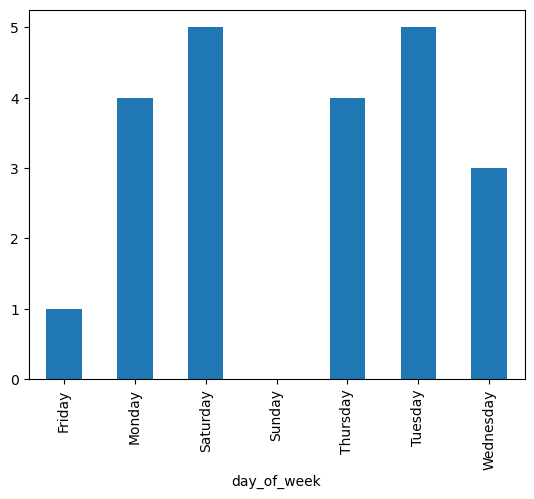

In [106]:
df_temp=df.groupby(['day_of_week'])['AQI_Bucket'].agg(lambda x:x.value_counts().index[0])
df_temp.plot(kind='bar')
plt.show()

<font color=green> ***So we can see the average is almost same for all the days of month, weekdays and hour of day, but when we look the most common value(mode) we see that it changes as these factors change***

In [115]:
df_temp = df.groupby('day_of_week')['AQI_Bucket'].agg(lambda x:list(x.value_counts()))
df_temp.head(7)

day_of_week
Friday       [10200, 10158, 10086, 10054, 10045, 10029, 10021]
Monday        [10180, 10168, 10143, 10043, 10041, 10028, 9963]
Saturday     [10201, 10176, 10160, 10146, 10102, 10087, 10034]
Sunday       [10204, 10189, 10154, 10122, 10105, 10039, 10008]
Thursday      [10176, 10134, 10111, 10087, 10084, 10053, 9987]
Tuesday      [10385, 10343, 10112, 10109, 10096, 10031, 10000]
Wednesday     [10333, 10217, 10121, 10107, 10087, 10084, 9969]
Name: AQI_Bucket, dtype: object

<font color=green>***But again here it is visible by looking at the value counts that all categories appear almost equally***

In [93]:
df['Datetime'] = pd.to_datetime(df['Datetime'])
df['day_of_week'] = df['Datetime'].dt.day_name()

### Feature Engg - Prepration for Modeling

In [7]:
df.head()

,City,Datetime,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI_Bucket,month,week,day,hour
0,Jaipur,2019-05-04 01:00:00,60.8,91.5,41.6,37.3,66.7,27.0,1.0,10.5,26.9,2.0,7.6,3.1,5,5,18,4,1
1,Amritsar,2017-04-27 19:00:00,23.8,119.1,14.9,17.1,NaN,28.4,0.0,6.7,19.1,3.1,8.7,3.1,5,4,17,27,19
2,Amaravati,2018-11-12 10:00:00,93.8,182.0,5.5,63.9,NaN,1.8,1.3,23.1,41.7,0.1,0.6,3.1,5,11,46,12,10
3,Kochi,2020-06-19 09:00:00,16.0,26.9,17.4,0.9,0.0,23.6,1.6,27.4,34.8,3.1,0.0,3.1,5,6,25,19,9
4,Ahmedabad,2019-05-16 03:00:00,29.5,138.4,NaN,31.6,26.0,23.6,9.3,NaN,36.9,14.5,86.8,11.5,1,5,20,16,3


#### Fill NA with Previous Values

In [8]:
# df_temp=df.drop(['Date'],axis=1)
df_temp=df
df_temp.sort_values(['City','Datetime'],ascending=True)
df_prep=df_temp.fillna(method='ffill')

In [9]:
df_prep.isna().sum()

City          0
Datetime      0
PM2.5         0
PM10          0
NO            0
NO2           0
NOx           0
NH3           0
CO            0
SO2           0
O3            0
Benzene       0
Toluene       0
Xylene        0
AQI_Bucket    0
month         0
week          0
day           0
hour          0
dtype: int64

<font color=green>*All the null values are replaced by the previous record in that city on that particular day*

#### One Hot Encoding and Stnd Scaler

In [10]:
df_prep.drop(['Datetime'],axis=1,inplace=True)

In [11]:
df_prep.columns

Index(['City', 'PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3',
       'Benzene', 'Toluene', 'Xylene', 'AQI_Bucket', 'month', 'week', 'day',
       'hour'],
      dtype='object')

In [12]:
# one Hot Encoding - ['City','month', 'week', 'day','hour']

city_one_hot = pd.get_dummies(df['City'])
month_one_hot = pd.get_dummies(df['month'], prefix='month')
week_one_hot = pd.get_dummies(df['week'], prefix='week')
day_one_hot = pd.get_dummies(df['day'])
hour_one_hot = pd.get_dummies(df['hour'], prefix='hour')

In [13]:
df_prep = pd.concat([df_prep, city_one_hot, month_one_hot, week_one_hot, day_one_hot, hour_one_hot], axis=1)

In [12]:
df_prep.shape

(495512, 164)

In [179]:
df_prep.columns

Index([   'City',   'PM2.5',    'PM10',      'NO',     'NO2',     'NOx',
           'NH3',      'CO',     'SO2',      'O3',
       ...
       'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19',
       'hour_20', 'hour_21', 'hour_22', 'hour_23'],
      dtype='object', length=164)

In [14]:
df_prep.drop(['City','month', 'week', 'day','hour'],axis=1,inplace=True)

In [15]:
df_prep.reset_index(inplace=True)

### Train Test Split

In [16]:
X_train,X_test,y_train,y_test=train_test_split(df_prep.drop(['AQI_Bucket'],axis=1),df_prep['AQI_Bucket'], test_size=0.2,random_state= 27)

### Scaling

In [17]:
from sklearn.preprocessing import StandardScaler

# create a StandardScaler object
scaler = StandardScaler()

# fit the scaler to the dataframe
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)


In [26]:
import joblib
joblib.dump(scaler,'scaler_AQI.joblib')

['scaler_AQI.joblib']

### Model Training

In [18]:
# Define the RMSLE scorer
def rmsle(y_true, y_pred):
    return np.sqrt(np.mean(np.power(np.log1p(y_true) - np.log1p(y_pred), 2)))

rmsle_scorer = make_scorer(rmsle, greater_is_better=False)

In [ ]:

# define the models to be tested and their respective hyperparameter grids
models = {
#     'Linear Regression': (LinearRegression(), {'normalize': [True, False]}),
#     'Ridge Regression': (Ridge(), {'alpha': [0.1, 1.0, 10.0]}),
#     'Support Vector Regression': (SVR(), {'C': [1, 10, 100], 'epsilon': [0.1, 0.01, 0.001]}),
#     'Decision Tree Regression': (DecisionTreeRegressor(), {'max_depth': [5, 10, 15]}),
    'Random Forest Regression': (RandomForestRegressor(), {'n_estimators': [50, 100, 200]})
}


# perform the grid search for each model
for name, (model, param_grid) in models.items():
   
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring=rmsle_scorer)
    grid_search.fit(X_train, y_train)
    train_score = rmsle(y_train, grid_search.predict(X_train))
    test_score = mean_squared_log_error(y_test, grid_search.predict(X_test)) ** 0.5
    
    
    print(f"{name} Train score: {train_score:.3f}, Test score: {test_score:.3f}, Best parameters: {grid_search.best_params_},Best score: {grid_search.best_score_:.3f}")

Linear Regression Train score: 0.656, Test score: 0.657, Best parameters: {'normalize': True},Best score: -0.656
Ridge Regression Train score: 0.656, Test score: 0.657, Best parameters: {'alpha': 0.1},Best score: -0.656


In [24]:

# Train the random forest model
rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf.fit(X_train, y_train)

# Make predictions on the test set
predictions = rf.predict(X_test)

# Evaluate the model's RMSLE
rmsle = mean_squared_log_error(y_test, predictions) ** 0.5
print("RMSLE: %.5f" % rmsle)

RMSLE: 0.65667


In [20]:
import xgboost as xgb
from sklearn.metrics import mean_squared_log_error


# Convert the data to DMatrix format for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Define the XGBoost parameters
params = {
    'max_depth': 3,
    'eta': 0.1,
    'objective': 'reg:squaredlogerror',
    'eval_metric': 'rmsle'
}

# Train the XGBoost model
model = xgb.train(params, dtrain, num_boost_round=100)

# Make predictions on the test set
predictions = model.predict(dtest)

# Evaluate the model's RMSLE
rmsle = mean_squared_log_error(y_test, predictions) ** 0.5
print("RMSLE: %.5f" % rmsle)


RMSLE: 0.63546


In [28]:
joblib.dump(model,'xgb_AQI.joblib')

['xgb_AQI.joblib']

In [31]:
df_py.head()

,City,Datetime,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI_Bucket,month,week,day,hour
0,Jaipur,2019-05-04 01:00:00,60.8,91.5,41.6,37.3,66.7,27.0,1.0,10.5,26.9,2.0,7.6,3.1,5,5,18,4,1
1,Amritsar,2017-04-27 19:00:00,23.8,119.1,14.9,17.1,66.7,28.4,0.0,6.7,19.1,3.1,8.7,3.1,5,4,17,27,19
2,Amaravati,2018-11-12 10:00:00,93.8,182.0,5.5,63.9,66.7,1.8,1.3,23.1,41.7,0.1,0.6,3.1,5,11,46,12,10
3,Kochi,2020-06-19 09:00:00,16.0,26.9,17.4,0.9,0.0,23.6,1.6,27.4,34.8,3.1,0.0,3.1,5,6,25,19,9
4,Ahmedabad,2019-05-16 03:00:00,29.5,138.4,17.4,31.6,26.0,23.6,9.3,27.4,36.9,14.5,86.8,11.5,1,5,20,16,3


In [29]:
# df_temp=df.drop(['Date'],axis=1)
df_temp=df
df_temp.sort_values(['City','Datetime'],ascending=True)
df_py=df_temp.fillna(method='ffill')

In [32]:
from pycaret.regression import *
s = setup(data = df_py, target = 'AQI_Bucket', session_id=123)

,Description,Value
0,Session id,123
1,Target,AQI_Bucket
2,Target type,Regression
3,Original data shape,"(495512, 19)"
4,Transformed data shape,"(495512, 21)"
5,Transformed train set shape,"(346858, 21)"
6,Transformed test set shape,"(148654, 21)"
7,Numeric features,16
8,Date features,1
9,Categorical features,1


In [33]:
best = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lasso,Lasso Regression,1.7143,4.0005,2.0001,-0.0000,0.6563,0.6071,0.5580
llar,Lasso Least Angle Regression,1.7143,4.0005,2.0001,-0.0000,0.6563,0.6071,0.5320
dummy,Dummy Regressor,1.7143,4.0005,2.0001,-0.0000,0.6563,0.6071,0.5770
en,Elastic Net,1.7143,4.0005,2.0001,-0.0000,0.6563,0.6071,0.5180
lr,Linear Regression,1.7153,4.0008,2.0002,-0.0001,0.6563,0.6074,2.0680
ridge,Ridge Regression,1.7153,4.0008,2.0002,-0.0001,0.6563,0.6074,0.5040
lar,Least Angle Regression,1.7151,4.0007,2.0002,-0.0001,0.6563,0.6074,0.5120
omp,Orthogonal Matching Pursuit,1.7147,4.0006,2.0001,-0.0001,0.6563,0.6072,0.5470
br,Bayesian Ridge,1.7151,4.0006,2.0001,-0.0001,0.6563,0.6073,0.6770
xgboost,Extreme Gradient Boosting,1.7150,4.0031,2.0008,-0.0007,0.6561,0.6066,16.7160


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

Going with XGBoost as knn didn't give results after making a model out of it

In [35]:
py_xgboost=create_model('xgboost')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.7171,4.0107,2.0027,-0.0001,0.6569,0.6066
1,1.7126,3.9937,1.9984,-0.0001,0.6536,0.6020
2,1.7168,4.0011,2.0003,-0.0001,0.6566,0.6114
3,1.7153,4.0083,2.0021,-0.0001,0.6575,0.6014
4,1.7211,4.0231,2.0058,-0.0002,0.6624,0.6095
5,1.7109,3.9948,1.9987,-0.0000,0.6551,0.6030
6,1.7150,4.0014,2.0004,-0.0004,0.6529,0.6079
7,1.7109,3.9880,1.9970,-0.0001,0.6524,0.6092
8,1.7132,3.9907,1.9977,-0.0006,0.6576,0.6077


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [37]:
tuned_xgb_py=tune_model(py_xgboost)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.7173,4.0107,2.0027,-0.0001,0.6569,0.6066
1,1.7133,3.9942,1.9986,-0.0002,0.6536,0.6022
2,1.7171,4.0016,2.0004,-0.0002,0.6565,0.6113
3,1.7157,4.0083,2.0021,-0.0001,0.6575,0.6017
4,1.7212,4.0232,2.0058,-0.0002,0.6624,0.6094
5,1.7114,3.9951,1.9988,-0.0001,0.6551,0.6032
6,1.7134,3.9995,1.9999,0.0001,0.6529,0.6075
7,1.7113,3.9883,1.9971,-0.0001,0.6523,0.6092
8,1.7138,3.9926,1.9981,-0.0011,0.6575,0.6075


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


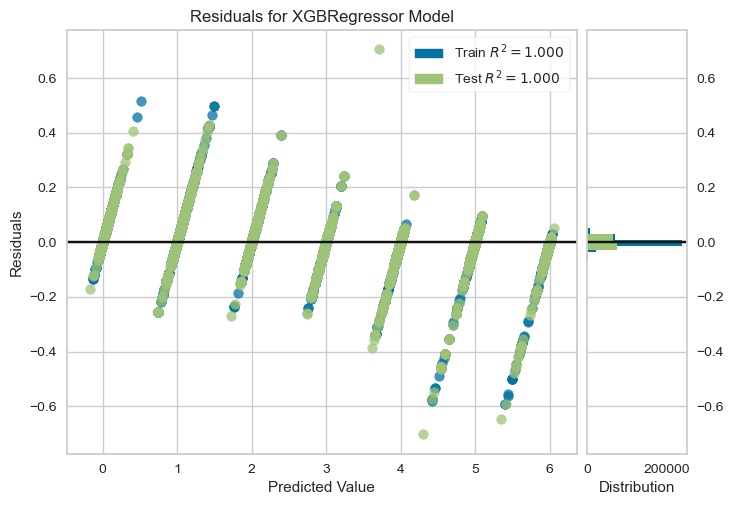

In [38]:
plot_model(tuned_xgb_py)

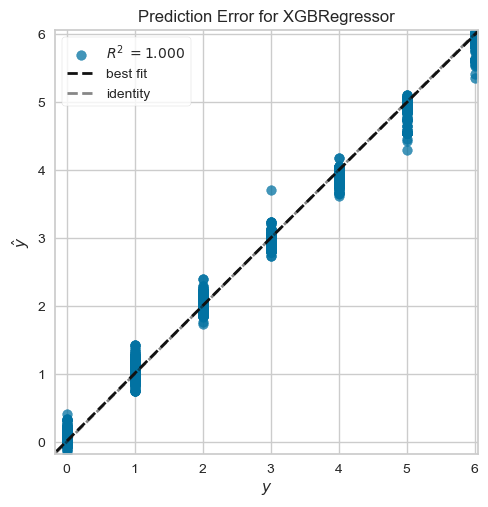

In [39]:
plot_model(tuned_xgb_py,plot='error')

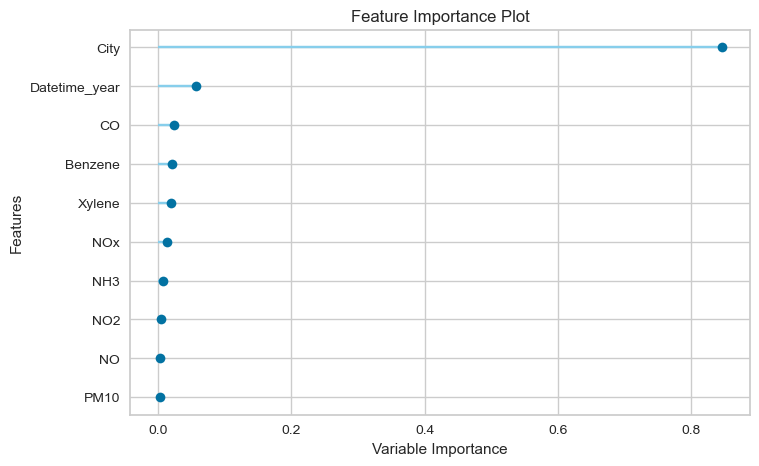

In [40]:
plot_model(tuned_xgb_py,plot='feature')

In [42]:
predict_model(tuned_xgb_py)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extreme Gradient Boosting,0.0101,0.0005,0.0214,0.9999,0.0099,0.0037


,City,Datetime,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,month,week,day,hour,AQI_Bucket,prediction_label
413128,Hyderabad,2019-06-15 23:00:00,24.799999,58.900002,2.1,15.300000,9.600000,7.300000,0.4,32.099998,22.799999,0.6,2.000000,0.5,6,24,15,23,1,1.002120
401180,Patna,2018-04-06 08:00:00,83.199997,119.099998,8.1,15.200000,8.800000,23.600000,1.1,47.900002,38.799999,0.2,2.900000,0.6,4,14,6,8,4,3.995363
119764,Ahmedabad,2015-07-17 04:00:00,41.500000,119.099998,0.8,7.800000,8.600000,23.600000,0.8,24.500000,2.800000,1.6,1.400000,0.0,7,29,17,4,4,3.996867
464062,Gurugram,2017-01-20 10:00:00,148.199997,119.099998,5.6,9.900000,32.299999,23.600000,0.8,7.900000,4.600000,4.7,47.200001,3.1,1,3,20,10,6,5.990499
282387,Patna,2017-08-27 12:00:00,67.599998,119.099998,17.4,28.900000,32.299999,23.600000,2.2,14.000000,34.799999,3.1,8.700000,3.1,8,34,27,12,5,4.995457
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195305,Bhopal,2020-01-18 10:00:00,65.800003,101.000000,6.0,29.799999,20.799999,19.799999,0.8,13.900000,42.799999,3.1,8.700000,3.1,1,3,18,10,0,0.060824
430041,Hyderabad,2019-05-04 23:00:00,27.200001,113.800003,1.2,32.599998,18.200001,9.400000,0.5,11.700000,33.200001,0.9,5.600000,1.3,5,18,4,23,1,1.002120
438593,Thiruvananthapuram,2017-06-19 21:00:00,67.599998,119.099998,17.4,28.900000,32.299999,23.600000,2.2,14.000000,34.799999,3.1,8.700000,3.1,6,25,19,21,1,1.007909
50559,Patna,2019-07-10 11:00:00,43.500000,119.099998,6.7,38.599998,14.000000,23.600000,0.9,43.500000,67.300003,0.7,4.900000,3.0,7,28,10,11,2,2.004909


In [43]:
predict_model(tuned_xgb_py)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extreme Gradient Boosting,0.0101,0.0005,0.0214,0.9999,0.0099,0.0037


,City,Datetime,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,month,week,day,hour,AQI_Bucket,prediction_label
413128,Hyderabad,2019-06-15 23:00:00,24.799999,58.900002,2.1,15.300000,9.600000,7.300000,0.4,32.099998,22.799999,0.6,2.000000,0.5,6,24,15,23,1,1.002120
401180,Patna,2018-04-06 08:00:00,83.199997,119.099998,8.1,15.200000,8.800000,23.600000,1.1,47.900002,38.799999,0.2,2.900000,0.6,4,14,6,8,4,3.995363
119764,Ahmedabad,2015-07-17 04:00:00,41.500000,119.099998,0.8,7.800000,8.600000,23.600000,0.8,24.500000,2.800000,1.6,1.400000,0.0,7,29,17,4,4,3.996867
464062,Gurugram,2017-01-20 10:00:00,148.199997,119.099998,5.6,9.900000,32.299999,23.600000,0.8,7.900000,4.600000,4.7,47.200001,3.1,1,3,20,10,6,5.990499
282387,Patna,2017-08-27 12:00:00,67.599998,119.099998,17.4,28.900000,32.299999,23.600000,2.2,14.000000,34.799999,3.1,8.700000,3.1,8,34,27,12,5,4.995457
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195305,Bhopal,2020-01-18 10:00:00,65.800003,101.000000,6.0,29.799999,20.799999,19.799999,0.8,13.900000,42.799999,3.1,8.700000,3.1,1,3,18,10,0,0.060824
430041,Hyderabad,2019-05-04 23:00:00,27.200001,113.800003,1.2,32.599998,18.200001,9.400000,0.5,11.700000,33.200001,0.9,5.600000,1.3,5,18,4,23,1,1.002120
438593,Thiruvananthapuram,2017-06-19 21:00:00,67.599998,119.099998,17.4,28.900000,32.299999,23.600000,2.2,14.000000,34.799999,3.1,8.700000,3.1,6,25,19,21,1,1.007909
50559,Patna,2019-07-10 11:00:00,43.500000,119.099998,6.7,38.599998,14.000000,23.600000,0.9,43.500000,67.300003,0.7,4.900000,3.0,7,28,10,11,2,2.004909


In [44]:
final_xgb=finalize_model(tuned_xgb_py)

In [45]:
print(final_xgb)

Pipeline(memory=FastMemory(location=C:\Users\RAJAT~1.SHA\AppData\Local\Temp\joblib),
         steps=[('date_feature_extractor',
                 TransformerWrapper(include=['Datetime'],
                                    transformer=ExtractDateTimeFeatures())),
                ('numerical_imputer',
                 TransformerWrapper(include=['PM2.5', 'PM10', 'NO', 'NO2',
                                             'NOx', 'NH3', 'CO', 'SO2', 'O3',
                                             'Benzene', 'Toluene', 'Xylene',
                                             'month', 'week', 'day',...
                              feature_types=None, gamma=None, gpu_id=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                             

In [47]:
save_model(final_xgb,'Pycaret_XGB_AQI')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=FastMemory(location=C:\Users\RAJAT~1.SHA\AppData\Local\Temp\joblib),
          steps=[('date_feature_extractor',
                  TransformerWrapper(include=['Datetime'],
                                     transformer=ExtractDateTimeFeatures())),
                 ('numerical_imputer',
                  TransformerWrapper(include=['PM2.5', 'PM10', 'NO', 'NO2',
                                              'NOx', 'NH3', 'CO', 'SO2', 'O3',
                                              'Benzene', 'Toluene', 'Xylene',
                                              'month', 'week', 'day',...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
               

In [34]:
knn=create_model('knn')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.8500,4.7977,2.1904,-0.1964,0.6921,0.6620
1,1.8570,4.8201,2.1955,-0.2071,0.6910,0.6612
2,1.8461,4.7692,2.1838,-0.1921,0.6911,0.6642
3,1.8642,4.8473,2.2017,-0.2094,0.6949,0.6657
4,1.8604,4.8383,2.1996,-0.2029,0.6994,0.6689
5,1.8534,4.8205,2.1956,-0.2067,0.6932,0.6599
6,1.8523,4.7925,2.1892,-0.1982,0.6886,0.6616
7,1.8487,4.7960,2.1900,-0.2027,0.6892,0.6685
8,1.8499,4.7798,2.1863,-0.1984,0.6932,0.6643


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

### Predicting on test data

In [49]:
saved_model=load_model('Pycaret_XGB_AQI')

Transformation Pipeline and Model Successfully Loaded


In [50]:
test=pd.read_csv(r"D:\Hackathons\Machine Hack\AQI\test.csv")

In [52]:
test['Datetime']=pd.to_datetime(test['Datetime'])
test['month']=test['Datetime'].dt.month
test['week']=test['Datetime'].dt.week
test['day']=test['Datetime'].dt.day
test['hour']=test['Datetime'].dt.hour

In [53]:
new_predictions=predict_model(saved_model,data=test)
new_predictions.head()

,City,Datetime,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,month,week,day,hour,prediction_label
0,Shillong,2019-11-02 02:00:00,67.599998,119.099998,17.4,28.900000,32.299999,23.600000,2.2,14.0,34.799999,3.1,8.7,3.1,11,44,2,2,3.022094
1,Patna,2019-11-27 11:00:00,265.000000,119.099998,34.0,38.700001,48.200001,23.600000,1.0,20.4,48.500000,2.6,7.0,6.7,11,48,27,11,3.001950
2,Patna,2020-01-06 01:00:00,86.300003,117.400002,19.1,20.299999,38.700001,30.100000,1.4,8.2,15.900000,2.3,0.7,3.1,1,2,6,1,3.004959
3,Shillong,2020-01-18 08:00:00,10.500000,13.300000,0.8,2.400000,1.000000,2.500000,0.1,7.2,55.900002,0.1,0.0,3.1,1,3,18,8,3.008818
4,Delhi,2020-02-17 14:00:00,82.900002,158.699997,11.8,36.700001,31.000000,36.700001,0.6,12.1,78.800003,3.6,18.9,0.1,2,8,17,14,3.000914


In [54]:
df_res=new_predictions['prediction_label']

In [55]:
df_res.to_csv('result.csv',index=False)

In [56]:
df_res.shape

(212363,)